Code for producing monthly sea ice motion and sea ice concentration standard deviation maps Figure 5

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import glob
import pandas as pd
import os
import cartopy
import cartopy.crs as ccrs
import scipy
from netCDF4 import Dataset,num2date, date2num
from scipy import interpolate
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.prepared import prep
from shapely.geometry import Point

Centre grid shape =  (58, 131)
Edges grid shape =  (59, 132)


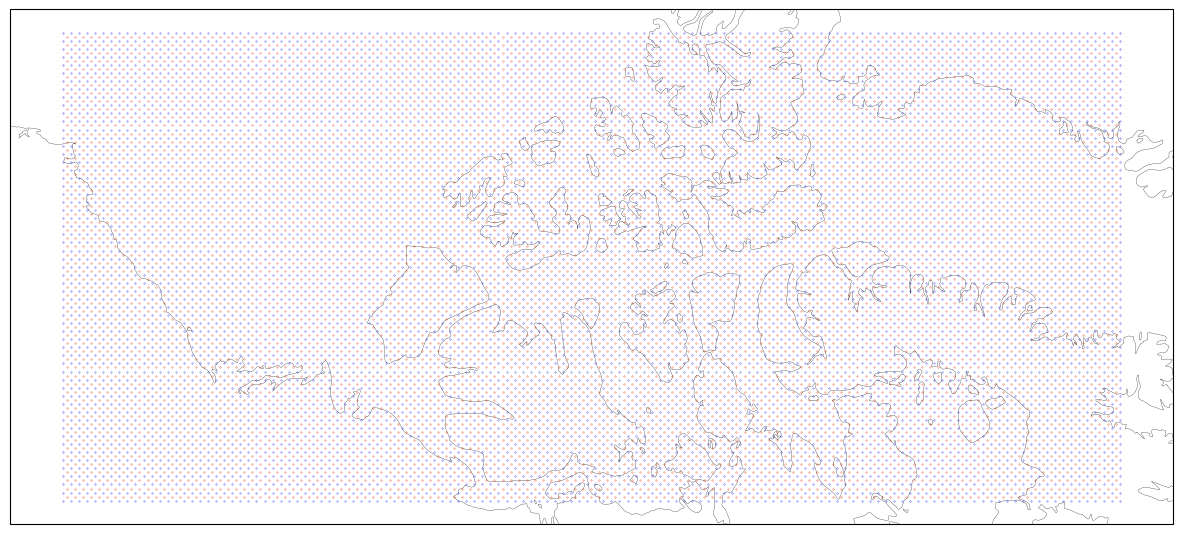

In [3]:
# Define the custom Lambert Azimuthal Equal Area projection
map_projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-105,central_latitude=74)

# Coordinates to transform (lon, lat) in the Plate Carree projection
geo_extent = [-140, -70, 64, 79]

def transform_coords(lon, lat, projection):
    x, y = projection.transform_point(lon, lat, ccrs.PlateCarree())
    return x, y

# Get corners of 'bounding box' from geo_extent
corners = [
    (geo_extent[0], geo_extent[2]),  # SW corner
    (geo_extent[1], geo_extent[2]),  # SE corner
    (geo_extent[0], geo_extent[3]),  # NW corner
    (geo_extent[1], geo_extent[3])   # NE corner
]

# Transform coordinates to the desired map area
proj_corners = [transform_coords(lon, lat, map_projection) for lon, lat in corners]
x_coords, y_coords = zip(*proj_corners)

x_min, x_max = min(x_coords), max(x_coords)
y_min, y_max = min(y_coords), max(y_coords)

grid_spacing = 25000 # 25 km

x_grid_centre = np.arange(x_min-grid_spacing/2,x_max + grid_spacing/2, grid_spacing)
y_grid_centre = np.arange(y_min-grid_spacing/2,y_max + grid_spacing/2, grid_spacing)
new_x_centre, new_y_centre = np.meshgrid(x_grid_centre, y_grid_centre) # For PMV & CIS data (regridded)

x_grid_edge = np.arange(x_min-grid_spacing,x_max + grid_spacing, grid_spacing)
y_grid_edge = np.arange(y_min-grid_spacing,y_max + grid_spacing, grid_spacing)
new_x_edge, new_y_edge= np.meshgrid(x_grid_edge, y_grid_edge) # For CS2 data (gridded)

print('Centre grid shape = ',np.shape(new_x_centre)) 
print('Edges grid shape = ',np.shape(new_x_edge)) # edges should be one greater than centres

# Set up the figure
fig = plt.figure(figsize=(15, 20))
ax = plt.axes(projection=map_projection)
ax.coastlines(linewidth=0.2)
ax.scatter(new_x_centre,new_y_centre,0.05, color='red')
ax.scatter(new_x_edge,new_y_edge,0.05, color='blue')
plt.show()


In [8]:
def add_shapefile_to_plot(ax, gdf,color,edgecolor, linewidth):
    for geom in gdf.geometry:
        ax.add_geometries([geom], crs=map_projection, facecolor=color,edgecolor=edgecolor, linewidth=linewidth)

# Ice Motion

In [4]:
def calculating_velocity(data_lon, mean_u, mean_v):
    # Use the longitude in the motion calculation 
    data_lon_rad = np.radians(data_lon)

    u_east = mean_u * np.cos(data_lon_rad) + mean_v * np.sin(data_lon_rad) # E:   u * cos L  +  v * sin L
    v_north = -mean_u * np.sin(data_lon_rad) + mean_v * np.cos(data_lon_rad) # N:  -u * sin L  +  v * cos L
    
    speed = np.sqrt(u_east**2 + v_north**2)

    return(u_east, v_north, speed)

In [5]:
months = ['10','11','12','01','02','03','04','05']

mean_arrays_u, mean_arrays_v = {},{}

for month in months:
    im_u_arrays, im_v_arrays = [],[]
    for year in range(2010,2024):
        im_u = np.load('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/IceMotion/Monthly/'+str(year)+str(month)+'_Mean_IceMotion_U.npy')
        im_v = np.load('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/IceMotion/Monthly/'+str(year)+str(month)+'_Mean_IceMotion_V.npy')

        im_u_arrays.append(im_u)
        im_v_arrays.append(im_v)

    stacked_u = np.stack(im_u_arrays,axis=0)
    mean_array_u = np.nanmean(stacked_u,axis=0)
    mean_arrays_u[month] = mean_array_u

    stacked_v = np.stack(im_v_arrays,axis=0)
    mean_array_v = np.nanmean(stacked_v,axis=0)
    mean_arrays_v[month] = mean_array_v

/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_62145/4167616100.py:15: RuntimeWarning: Mean of empty slice
  mean_array_u = np.nanmean(stacked_u,axis=0)
/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_62145/4167616100.py:19: RuntimeWarning: Mean of empty slice
  mean_array_v = np.nanmean(stacked_v,axis=0)


# Ice Standard Deviation

In [6]:
months = ['10','11','12','01','02','03','04','05']
mean_stacked_stds = {}
for month in months:
    std_arrays = []
    for year in range(2010,2024):
        std_array = np.load('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/PMV_Daily_Std_All/'+str(year)+str(month)+'_PMV_Std_Array.npy')

        std_arrays.append(std_array)

    stacked_stds = np.stack(std_arrays,axis=0)
    mean_stacked_std = np.nanmean(stacked_stds,axis=0)
    mean_stacked_stds[month] = mean_stacked_std

/var/folders/q1/prwbhm6j6x1gcchb7r0p2kyh0000gn/T/ipykernel_62145/2548049973.py:11: RuntimeWarning: Mean of empty slice
  mean_stacked_std = np.nanmean(stacked_stds,axis=0)


# Plot

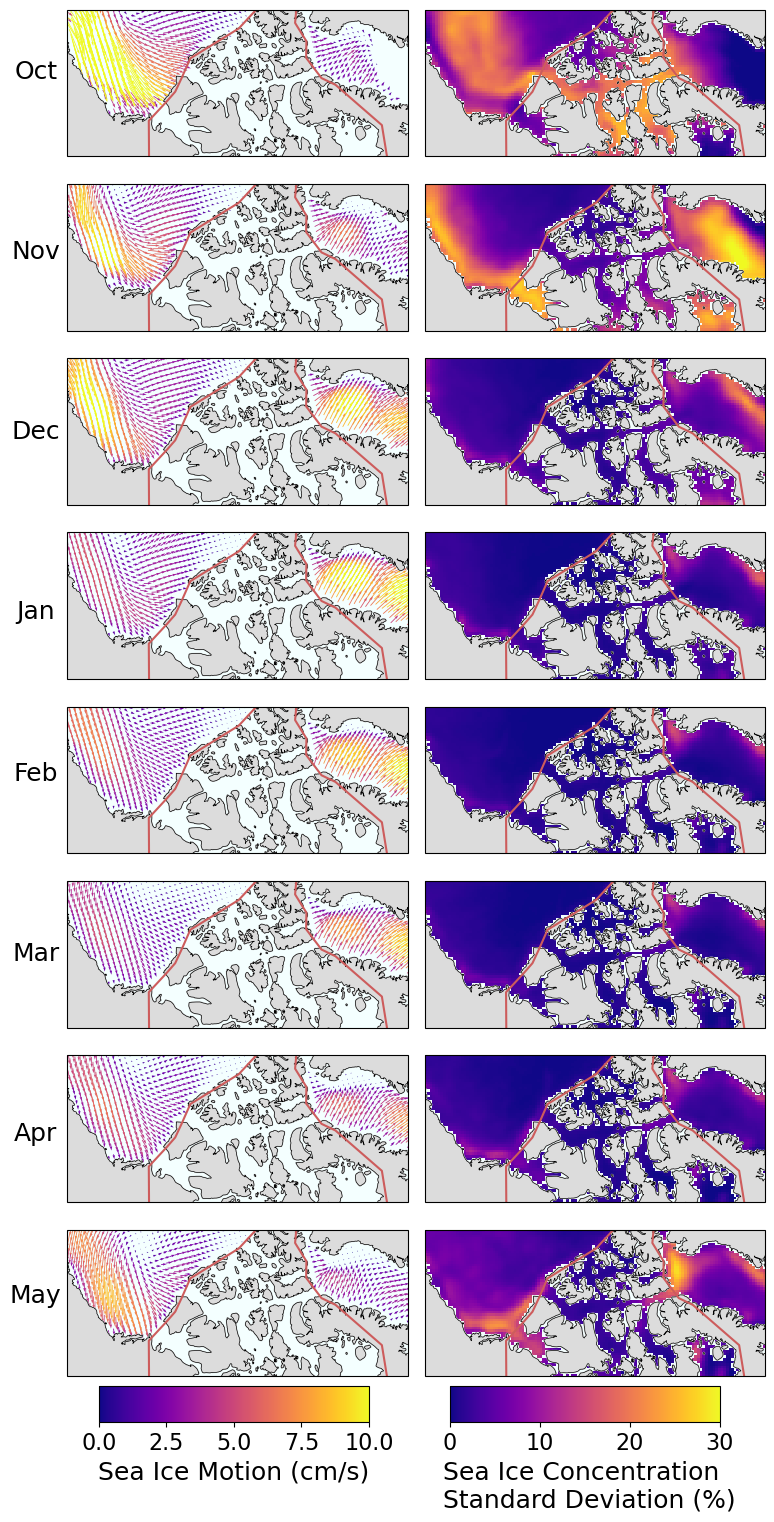

In [10]:
# Load an example lat / lon for the ice motion
test = Dataset('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC/IceMotion/icemotion_weekly_nh_25km_20100101_20101231_v4.1.nc')

data_x = test.variables['x'][:]
data_y = test.variables['y'][:]
data_x_50km = data_x[::2]
data_y_50km = data_y[::2]
data_lon = test.variables['longitude'][:]
data_lat = test.variables['latitude'][:]

# Import shapefiles of the desired regions
bs_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BeaufortSea_Shapefile.shp')
bb_shp = gpd.read_file('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/GIS_Processing/Regional_Shapefiles/BaffinBay_Shapefile.shp')

fig_a, axs_a = plt.subplots(8, 2, figsize=(9,18), subplot_kw={'projection':map_projection})

for i, month in enumerate(months):
    # Plot Motion
    u_east, v_north, speed = calculating_velocity(data_lon, mean_arrays_u[month], mean_arrays_v[month])

    u_east_50km = u_east[::2, ::2]
    v_north_50km = v_north[::2, ::2]
    speed_50km = speed[::2, ::2]

    # Quiver plot of ice motion
    q = axs_a[i,0].quiver(data_x_50km, data_y_50km, u_east_50km, v_north_50km, speed_50km,
        transform=ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90),
        scale=150, cmap='plasma', clim=(0, 10))
    axs_a[i,0].set_extent([x_min, x_max, y_min, y_max], crs=map_projection)
    axs_a[i,0].coastlines(linewidth=0.5)
    axs_a[i,0].add_feature(cfeature.LAND, color='gainsboro', zorder=1)
    axs_a[i,0].add_feature(cartopy.feature.OCEAN, color=('azure'), edgecolor='black', alpha=0.7, zorder=0)

    add_shapefile_to_plot(axs_a[i,0], bs_shp, color='none',edgecolor='IndianRed', linewidth=1.5)
    add_shapefile_to_plot(axs_a[i,0], bb_shp, color='none', edgecolor='IndianRed', linewidth=1.5)

    # Plot Ice Conc Std
    pcm = axs_a[i,1].pcolormesh(new_x_centre, new_y_centre, mean_stacked_stds[month],
                    cmap='plasma', transform=map_projection, vmin=0, vmax=30)
    axs_a[i,1].coastlines(linewidth=0.5)
    axs_a[i,1].set_extent([x_min, x_max, y_min, y_max], crs=map_projection)
    axs_a[i,1].add_feature(cartopy.feature.LAND, color='gainsboro',zorder=1)
    axs_a[i,1].add_feature(cartopy.feature.OCEAN, color=('azure'), edgecolor='black', alpha=0.7, zorder=0)

    add_shapefile_to_plot(axs_a[i,1], bs_shp, color='none',edgecolor='IndianRed', linewidth=1.5)
    add_shapefile_to_plot(axs_a[i,1], bb_shp, color='none', edgecolor='IndianRed', linewidth=1.5)


plt.subplots_adjust(wspace=0.05, hspace=0.05)

fig_a.text(0.09, 0.84, 'Oct', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.74, 'Nov', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.64, 'Dec', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.54, 'Jan', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.45, 'Feb', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.35, 'Mar', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.25, 'Apr', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)
fig_a.text(0.09, 0.16, 'May', va='center', ha='center', 
         rotation='horizontal', fontsize=18, transform=fig_a.transFigure)

cbar_ax = fig_a.add_axes([0.16, 0.09, 0.3, 0.02])  # left, bottom, width, height
cbar_1 = fig_a.colorbar(q, cax=cbar_ax, orientation='horizontal')
cbar_1.set_label('Sea Ice Motion (cm/s)', fontsize=18)
cbar_1.ax.tick_params(labelsize=16)

# Colorbar for Sea Ice Concentration Std
cbar_ax2 = fig_a.add_axes([0.55, 0.09, 0.3, 0.02])  # left, bottom, width, height
cbar_2 = fig_a.colorbar(pcm, cax=cbar_ax2, orientation='horizontal')
cbar_2.set_label('Sea Ice Concentration \n Standard Deviation (%)', fontsize=18)
cbar_2.ax.tick_params(labelsize=16)


plt.show()

fig_a.savefig('/Users/amyswiggs/Desktop/Autumn2023/Chapter2/Northumbria_Spring_Data/NWP_SIC_Plots/ReSubmission_Plots/Fig05_IceMotion_IceStd.png',dpi=300,bbox_inches="tight")